<a href="https://colab.research.google.com/github/Druvith/NN_from_scratch2023/blob/main/Atten1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install d2l==1.0.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 108.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 77.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.9/121.9 kB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 40.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 93.6 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.11.3
    Uninstalling scipy-1.11.3:
      Successfully uninstalled scipy-1.11.3
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.1
    Uninstalling pyparsing-3.1.1:

In [2]:
import math
import torch
from torch import nn
from d2l import torch as d2l

In [3]:
def masked_softmax(X, valid_lens):
  def _sequence_mask(X, valid_len, value=0):
    maxlen = X.size(1)
    mask = torch.arange((maxlen), dtype=torch.float32, device=X.device)[None, :] < valid_len[:, None]
    X[~mask] = value
    return X

  if valid_lens is None:
    return nn.functional.softmax(X, dim=-1)
  else:
    shape = X.shape
    if valid_lens.dim() == 1:
      valid_lens = torch.repeat_interleave(valid_lens, shape[1])
    else:
      valid_lens = valid_lens.reshape(-1)
    X = _sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)
    return nn.functional.softmax(X.reshape(shape), dim=-1)

In [4]:
class DotProductAttention(nn.Module):
  def __init__(self, dropout):
    super().__init__()
    self.dropout = nn.Dropout(dropout)

  def forward(self, queries, keys, values, valid_lens=None):
    d = queries.shape[-1]
    scores = torch.bmm(queries, keys.transpose(1,2) / math.sqrt(d))
    self.attention_weights = masked_softmax(scores, valid_lens)
    return torch.bmm(self.dropout(self.attention_weights), values)

In [5]:
queries = torch.normal(0,1,(2,1,2))
keys = torch.normal(0,1,(2,10,2))
values = torch.normal(0,1,(2,10,4))
valid_lens = torch.tensor([2,6])

attention = DotProductAttention(dropout=0.5)
attention.eval()
d2l.check_shape(attention(queries, keys, values, valid_lens), (2,1,4))

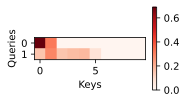

In [6]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')

In [7]:
#ADDITIVE ATTENTION

In [8]:
class AdditiveAttention(nn.Module):
  def __init__(self, num_hiddens, dropout, **kwargs):
    super(AdditiveAttention, self).__init__(**kwargs)
    self.W_k = nn.LazyLinear(num_hiddens, bias = False)
    self.W_q = nn.LazyLinear(num_hiddens, bias=False)
    self.w_v = nn.LazyLinear(1, bias=False)
    self.dropout = nn.Dropout(dropout)

  def forward(self, queries, keys, values, valid_lens):
    queries, keys = self.W_q(queries), self.W_k(keys)
    features = queries.unsqueeze(2) + keys.unsqueeze(1)
    features = torch.tanh(features)
    scores = self.w_v(features).squeeze(-1)
    self.attention_weights = masked_softmax(scores, valid_lens)
    return torch.bmm(self.dropout(self.attention_weights), values)

In [9]:
queries = torch.normal(0, 1, (2, 1, 20))

attention = AdditiveAttention(num_hiddens=8, dropout=0.1)
attention.eval()
d2l.check_shape(attention(queries, keys, values, valid_lens), (2, 1, 4))

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [10]:
queries = torch.normal(0, 1, (2, 1, 20))

attention = AdditiveAttention(num_hiddens=8, dropout=0.1)
attention.eval()
d2l.check_shape(attention(queries, keys, values, valid_lens), (2, 1, 4))

In [11]:
def masked_softmax(X, valid_lens):
  def _sequence_mask(X, valid_len, value=0):
    max_len = X.size(1)
    mask = torch.arange((max_len), dtype=torch.float32, device=X.device)[None, :] < valid_len[:, None]
    X[~mask] = value
    return X

  if valid_lens is None:
    return nn.function.softmax(X, dim=-1)
  else:
    shape = X.shape
    if valid_lens.dim() == 1:
      valid_lens = torch.repeat_interleave(valid_lens, shape[1])
    else:
      valid_lens = valid_lens.reshape(-1)

    X = _sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)
    return nn.functional.softmax(X.reshape(shape), dim=-1)

In [12]:
masked_softmax(torch.rand(2,2,4), torch.tensor([2,3]))

tensor([[[0.4046, 0.5954, 0.0000, 0.0000],
         [0.4775, 0.5225, 0.0000, 0.0000]],

        [[0.1752, 0.3535, 0.4713, 0.0000],
         [0.2849, 0.4868, 0.2282, 0.0000]]])

In [13]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([[1, 3], [2, 4]]))

tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.4037, 0.3675, 0.2287, 0.0000]],

        [[0.6159, 0.3841, 0.0000, 0.0000],
         [0.3874, 0.2571, 0.1718, 0.1837]]])

In [14]:
Q = torch.ones((2, 3, 4))
K = torch.ones((2, 4, 6))
d2l.check_shape(torch.bmm(Q, K), (2, 3, 6))

In [15]:
class DotProductAttention(nn.Module):
  def __init__(self, dropout):
    super().__init__()
    self.dropout = nn.Dropout(dropout)

  def forward(self, queries, keys, values, valid_lens=None):
    d = queries.shape[-1]
    scores = torch.bmm(queries, keys.transpose(1,2)) / math.sqrt(d)
    self.attention_weights = masked_softmax(scores, valid_lens)
    return torch.bmm(self.dropout(self.attention_weights), values)

In [16]:
queries = torch.normal(0,1,(2,1,2))
keys = torch.normal(0,1,(2,10,2))
values = torch.normal(0,1,(2,10,4))
valid_lens = torch.tensor([2,6])

attention = DotProductAttention(dropout=0.5)
attention.eval()
d2l.check_shape(attention(queries, keys, values, valid_lens), (2,1,4))

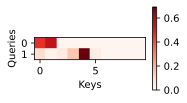

In [17]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')

In [18]:
class AdditiveAttention(nn.Module):
  def __init__(self, num_hiddens, dropout, **kwargs):
    super(AdditiveAttention, self).__init__(**kwargs)
    self.W_k = nn.LazyLinear(num_hiddens, bias=False)
    self.W_q = nn.LazyLinear(num_hiddens, bias=False)
    self.w_v = nn.LazyLinear(1, bias=False)
    self.dropout = nn.Dropout(dropout)

  def forward(self, queries, keys, values, valid_lens):
    queries, keys = self.W_q(queries), self.W_k(keys)
    features = queries.unsqueeze(2) + keys.unsqueeze(1)
    features = torch.tanh(features)
    scores = self.w_v(features).squeeze(-1)
    self.attention_weights = masked_softmax(scores, valid_lens)
    return torch.bmm(self.dropout(self.attention_weights), values)

In [19]:
queries = torch.normal(0, 1, (2, 1, 20))

attention = AdditiveAttention(num_hiddens=8, dropout=0.1)
attention.eval()
d2l.check_shape(attention(queries, keys, values, valid_lens), (2, 1, 4))

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


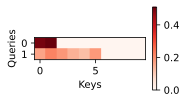

In [20]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')

In [21]:
#Distance Based Attention


In [25]:
class DistanceBasedAttention(nn.Module):
  def __init__(self, dropout, **kwargs):
    super(DistanceBasedAttention, self).__init__(**kwargs)
    self.dropout = nn.Dropout(dropout)

  def forward(self, queries, keys, values, valid_lens=None):
    squared_norm_keys = torch.sum(keys**2, dim=-1, keepdim=True)
    squared_norm_queries = torch.sum(queries**2, dim=-1, keepdim=True)
    scores = -2 * torch.bmm(queries, keys.transpose(1,2))
    scores += squared_norm_keys.transpose(1,2) + squared_norm_queries
    self.attention_weights = masked_softmax(scores, valid_lens)
    return torch.bmm(self.dropout(self.attention_weights), values)

In [27]:
queries = torch.normal(0, 1, (2, 1, 2))
keys = torch.ones((2, 10, 2))
values = torch.arange(40, dtype=torch.float32).reshape(1, 10, 4).repeat(2, 1, 1)
valid_lens = torch.tensor([2, 6])

attention = DistanceBasedAttention( dropout=0.1)
attention.eval()
d2l.check_shape(attention(queries, keys, values, valid_lens), (2, 1, 4))

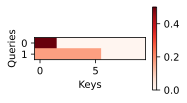

In [28]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')